In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

DataFrame Shape: (1968, 6)
Null Values Present: False


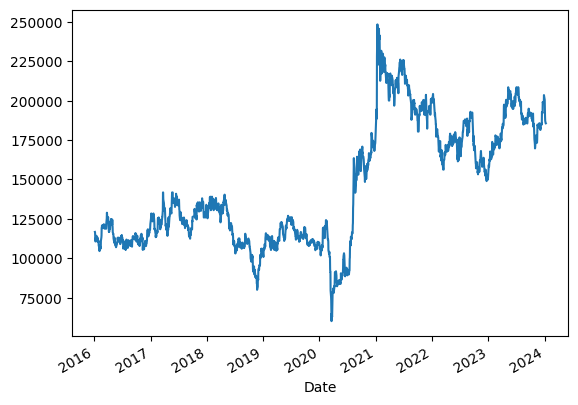

Epoch 1/200
50/50 [==============================] - 8s 48ms/step - loss: 0.0444 - val_loss: 0.0215 - lr: 0.0010
Epoch 2/200
50/50 [==============================] - 1s 13ms/step - loss: 0.0476 - val_loss: 0.0033 - lr: 0.0010
Epoch 3/200
50/50 [==============================] - 1s 14ms/step - loss: 0.0469 - val_loss: 0.0056 - lr: 0.0010
Epoch 4/200
50/50 [==============================] - 0s 9ms/step - loss: 0.0417 - val_loss: 0.0041 - lr: 0.0010
Epoch 5/200
50/50 [==============================] - 0s 10ms/step - loss: 0.0398 - val_loss: 0.0038 - lr: 0.0010
Epoch 6/200
50/50 [==============================] - 0s 10ms/step - loss: 0.0363 - val_loss: 0.0027 - lr: 0.0010
Epoch 7/200
50/50 [==============================] - 0s 9ms/step - loss: 0.0343 - val_loss: 0.0023 - lr: 0.0010
Epoch 8/200
50/50 [==============================] - 0s 9ms/step - loss: 0.0315 - val_loss: 0.0022 - lr: 0.0010
Epoch 9/200
50/50 [==============================] - 0s 9ms/step - loss: 0.0262 - val_loss: 0.0027 

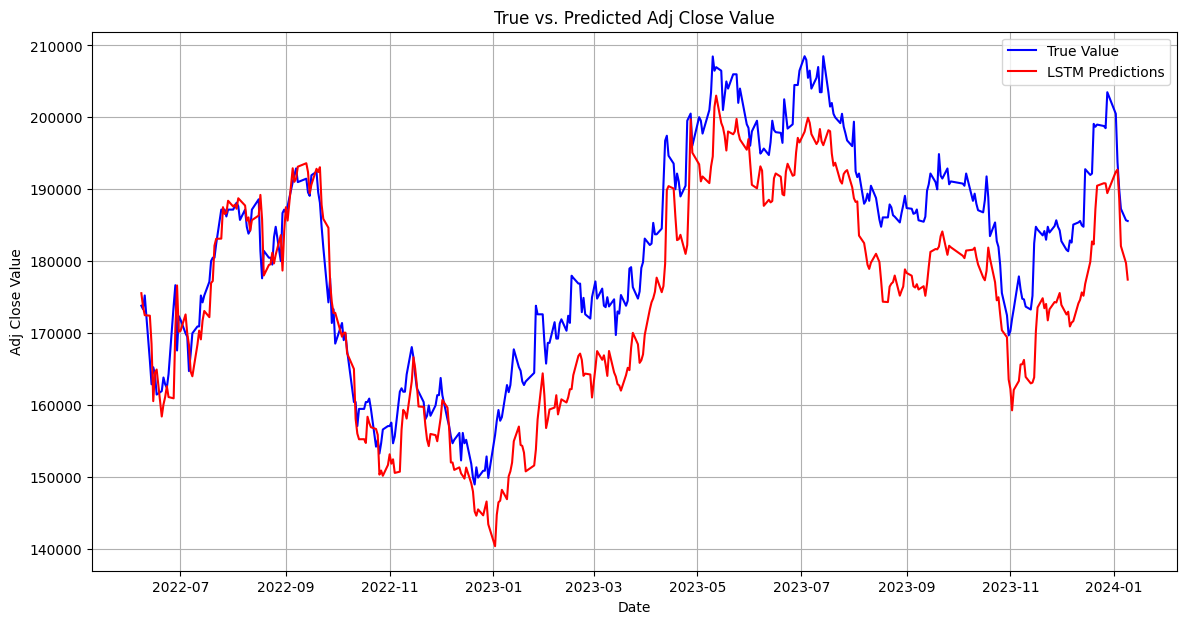

In [ ]:
# Get the Dataset
df = pd.read_csv("005380.KS.csv", na_values=['null'], index_col='Date', parse_dates=True, infer_datetime_format=True)

# Print the shape of DataFrame and Check for Null Values
print("DataFrame Shape:", df.shape)
print("Null Values Present:", df.isnull().values.any())

# Plot the True Adj Close Value
df['Adj Close'].plot()
plt.show()

# Set Target Variable and Selecting the Features
output_var = pd.DataFrame(df['Adj Close'])
features = ['Open', 'High', 'Low', 'Volume']

# Scaling both features and target variable
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

feature_transform = scaler_features.fit_transform(df[features])
output_transform = scaler_target.fit_transform(output_var)

feature_transform = pd.DataFrame(columns=features, data=feature_transform, index=df.index)

# Splitting the data into train and test sets
train_size = int(len(df) * 0.8)
train, test = feature_transform[:train_size], feature_transform[train_size:]
train_output, test_output = output_transform[:train_size], output_transform[train_size:]

# Reshaping the data for LSTM
X_train = train.values.reshape(train.shape[0], 1, train.shape[1])
X_test = test.values.reshape(test.shape[0], 1, test.shape[1])

# Building a more complex LSTM Model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(Dense(1))
opt = Adam(clipvalue=0.5)

# Adding learning rate scheduling
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

model.compile(optimizer=opt, loss='mse')
history = model.fit(X_train, train_output, epochs=200, batch_size=32,
                    validation_data=(X_test, test_output), shuffle=False,
                    callbacks=[reduce_lr])

# Make predictions
predictions = model.predict(X_test)

# Transform predictions back to original scale
# Ensure the lengths match for plotting
test_dates_for_predictions = df.index[train_size + 1:train_size + 1 + len(predictions)]
predictions = predictions[:len(test_dates_for_predictions)]

# Inverse transform to get the original scale
predictions = scaler_target.inverse_transform(predictions.reshape(-1, 1))

# Plotting
plt.figure(figsize=(14, 7))

# Plot the true values
plt.plot(test_dates_for_predictions, df['Adj Close'].values[train_size + 1:train_size + 1 + len(predictions)],
         label='True Value', color='blue')

# Plot the LSTM predictions
plt.plot(test_dates_for_predictions, predictions, label='LSTM Predictions', color='red')

# Setting labels and title
plt.xlabel('Date')
plt.ylabel('Adj Close Value')
plt.title('True vs. Predicted Adj Close Value')
plt.legend()
plt.grid(True)
plt.show()